In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pydicom
import numpy as np
import os
import glob
from tqdm import tqdm
import warnings
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [5]:
# the path to the dataset

train_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/'
# Load CSV files
train = pd.read_csv(train_path + 'train.csv')
label = pd.read_csv(train_path + 'train_label_coordinates.csv')
train_description = pd.read_csv(train_path + 'train_series_descriptions.csv')
test_description = pd.read_csv(train_path + 'test_series_descriptions.csv')
submission = pd.read_csv(train_path + 'sample_submission.csv')


In [6]:
train.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1975 entries, 0 to 1974
Data columns (total 26 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   study_id                                1975 non-null   int64 
 1   spinal_canal_stenosis_l1_l2             1974 non-null   object
 2   spinal_canal_stenosis_l2_l3             1974 non-null   object
 3   spinal_canal_stenosis_l3_l4             1974 non-null   object
 4   spinal_canal_stenosis_l4_l5             1974 non-null   object
 5   spinal_canal_stenosis_l5_s1             1974 non-null   object
 6   left_neural_foraminal_narrowing_l1_l2   1973 non-null   object
 7   left_neural_foraminal_narrowing_l2_l3   1973 non-null   object
 8   left_neural_foraminal_narrowing_l3_l4   1973 non-null   object
 9   left_neural_foraminal_narrowing_l4_l5   1973 non-null   object
 10  left_neural_foraminal_narrowing_l5_s1   1973 non-null   object
 11  righ

In [8]:
label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48692 entries, 0 to 48691
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   study_id         48692 non-null  int64  
 1   series_id        48692 non-null  int64  
 2   instance_number  48692 non-null  int64  
 3   condition        48692 non-null  object 
 4   level            48692 non-null  object 
 5   x                48692 non-null  float64
 6   y                48692 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 2.6+ MB


In [9]:
label.head()

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602


In [10]:
train_description.head()

,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1


In [11]:
test_description.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   study_id            3 non-null      int64 
 1   series_id           3 non-null      int64 
 2   series_description  3 non-null      object
dtypes: int64(2), object(1)
memory usage: 200.0+ bytes


In [14]:
test_description.head()

,study_id,series_id,series_description
0,44036939,2828203845,Sagittal T1
1,44036939,3481971518,Axial T2
2,44036939,3844393089,Sagittal T2/STIR


In [15]:
submission.head()

,row_id,normal_mild,moderate,severe
0,44036939_left_neural_foraminal_narrowing_l1_l2,0.333333,0.333333,0.333333
1,44036939_left_neural_foraminal_narrowing_l2_l3,0.333333,0.333333,0.333333
2,44036939_left_neural_foraminal_narrowing_l3_l4,0.333333,0.333333,0.333333
3,44036939_left_neural_foraminal_narrowing_l4_l5,0.333333,0.333333,0.333333
4,44036939_left_neural_foraminal_narrowing_l5_s1,0.333333,0.333333,0.333333


### Generate Image Paths and Visualize with OpenCV

In [16]:
import os
import cv2
import matplotlib.pyplot as plt

# Function to generate image paths based on directory structure
def generate_image_paths(df, data_dir):
    image_paths = []
    for study_id, series_id in zip(df['study_id'], df['series_id']):
        study_dir = os.path.join(data_dir, str(study_id))
        series_dir = os.path.join(study_dir, str(series_id))
        images = os.listdir(series_dir)
        image_paths.extend([os.path.join(series_dir, img) for img in images])
    return image_paths

# Generate image paths for train and test data
train_image_paths = generate_image_paths(train_description, f'{train_path}/train_images')
test_image_paths = generate_image_paths(test_description, f'{train_path}/test_images')

# Function to visualize images using OpenCV
def visualize_image(image_path):
    # Read the image using OpenCV
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # OpenCV reads images in BGR format, so no need to convert for grayscale
    if img is None:
        print(f"Image not found at path: {image_path}")
        return
    
    # Display the image using Matplotlib for better color support
    plt.imshow(img, cmap='rgb')
    plt.title(f"Image: {os.path.basename(image_path)}")
    plt.axis('off')  # Hide axis for better visualization
    plt.show()

In [17]:
# Generate image paths for train and test data
train_image_paths = generate_image_paths(train_description, f'{train_path}/train_images')
test_image_paths = generate_image_paths(test_description, f'{train_path}/test_images')


In [18]:
# Function to visualize images using OpenCV
def visualize_image(image_path):
    if image_path.endswith('.dcm'):
        # Handle DICOM images
        import pydicom
        ds = pydicom.dcmread(image_path)
        img = ds.pixel_array  # Extract image array from DICOM file
        
        plt.imshow(img, cmap='gray')
        plt.title(f"DICOM Image: {os.path.basename(image_path)}")
        plt.axis('off')
        plt.show()
    else:
        # Read the image using OpenCV
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            print(f"Image not found or unsupported format at path: {image_path}")
            return
        
        plt.imshow(img, cmap='gray')
        plt.title(f"Image: {os.path.basename(image_path)}")
        plt.axis('off')
        plt.show()


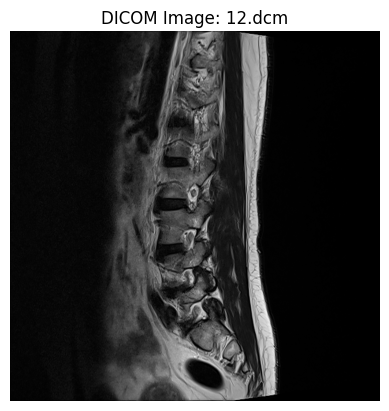

In [19]:
# visualize the first valid image in the train dataset
if train_image_paths:
    visualize_image(train_image_paths[0])
else:
    print("No valid image paths found.")

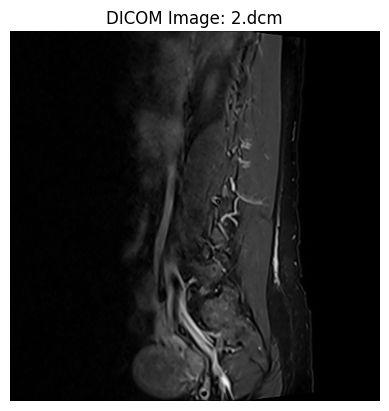

In [20]:
# visualize the first valid image in the train dataset
if train_image_paths:
    visualize_image(train_image_paths[5846])
else:
    print("No valid image paths found.")

In [22]:
# Check the columns of the train DataFrame
print(train.columns)


Index(['study_id', 'spinal_canal_stenosis_l1_l2',
       'spinal_canal_stenosis_l2_l3', 'spinal_canal_stenosis_l3_l4',
       'spinal_canal_stenosis_l4_l5', 'spinal_canal_stenosis_l5_s1',
       'left_neural_foraminal_narrowing_l1_l2',
       'left_neural_foraminal_narrowing_l2_l3',
       'left_neural_foraminal_narrowing_l3_l4',
       'left_neural_foraminal_narrowing_l4_l5',
       'left_neural_foraminal_narrowing_l5_s1',
       'right_neural_foraminal_narrowing_l1_l2',
       'right_neural_foraminal_narrowing_l2_l3',
       'right_neural_foraminal_narrowing_l3_l4',
       'right_neural_foraminal_narrowing_l4_l5',
       'right_neural_foraminal_narrowing_l5_s1',
       'left_subarticular_stenosis_l1_l2', 'left_subarticular_stenosis_l2_l3',
       'left_subarticular_stenosis_l3_l4', 'left_subarticular_stenosis_l4_l5',
       'left_subarticular_stenosis_l5_s1', 'right_subarticular_stenosis_l1_l2',
       'right_subarticular_stenosis_l2_l3',
       'right_subarticular_stenosis_l3_l4',
 

## structure df 

In [23]:
structured_df = []

for _, row in train.iterrows():
    df = {
        'study_id': [],
        'condition': [],
        'level': [],
        'severity': []
    }
    
    for column, value in row.items():
        if column not in ['study_id', 'series_id', 'instance_number', 'x', 'y', 'series_description']:
            parts = column.split('_')
            condition = ' '.join([word.capitalize() for word in parts[:-2]])
            level = f"{parts[-2].capitalize()}/{parts[-1].capitalize()}"
            
            df['study_id'].append(row['study_id'])
            df['condition'].append(condition)
            df['level'].append(level)
            df['severity'].append(value)
    
    structured_df.append(pd.DataFrame(df))

# Concatenate reshaped data
structured_df = pd.concat(structured_df, ignore_index=True)



In [24]:
print(structured_df.info())
structured_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49375 entries, 0 to 49374
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   study_id   49375 non-null  int64 
 1   condition  49375 non-null  object
 2   level      49375 non-null  object
 3   severity   48803 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.5+ MB
None


,study_id,condition,level,severity
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild


## Merge the df with labels

In [25]:
merged_df = pd.merge(structured_df, label, on = ['study_id', 'condition', 'level'], how ='inner')

final_df = pd.merge(merged_df, train_description, on=['series_id', 'study_id'], how='inner')


In [26]:
print("Final DataFrames")
print(final_df.info())
final_df.head()

Final DataFrames
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48692 entries, 0 to 48691
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   study_id            48692 non-null  int64  
 1   condition           48692 non-null  object 
 2   level               48692 non-null  object 
 3   severity            48657 non-null  object 
 4   series_id           48692 non-null  int64  
 5   instance_number     48692 non-null  int64  
 6   x                   48692 non-null  float64
 7   y                   48692 non-null  float64
 8   series_description  48692 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 3.3+ MB
None


,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR


In [27]:
print(final_df['severity'].unique())


['Normal/Mild' 'Moderate' 'Severe' nan]


##  Mapring severity levels

In [28]:
final_df['severity'] = final_df['severity'].map({
    'Normal/Mild': 'normal_mild', 
    'Moderate': 'moderate', 
    'Severe': 'severe'
})
print("Dataframe with severity levels")
final_df[['study_id', 'condition', 'level', 'severity']].head()


Dataframe with severity levels


,study_id,condition,level,severity
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild
3,4003253,Spinal Canal Stenosis,L4/L5,normal_mild
4,4003253,Spinal Canal Stenosis,L5/S1,normal_mild


## unique row ID for each image path

In [29]:
final_df['row_id'] = (
    final_df['study_id'].astype(str) + '_' +
    final_df['condition'].str.lower().str.replace(' ', '_') + '_' +
    final_df['level'].str.lower().str.replace('/', '_')
)

In [30]:
# verify that our row id is created
final_df.head()

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4
3,4003253,Spinal Canal Stenosis,L4/L5,normal_mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l4_l5
4,4003253,Spinal Canal Stenosis,L5/S1,normal_mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l5_s1


## include images into df

In [31]:
final_df['image_path'] = (
    f'{train_path}/train_images/' + 
    final_df['study_id'].astype(str) + '/' +
    final_df['series_id'].astype(str) + '/' +
    final_df['instance_number'].astype(str) + '.dcm'
)


In [32]:
print("Created image paths")
final_df.head()

Created image paths


,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
3,4003253,Spinal Canal Stenosis,L4/L5,normal_mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l4_l5,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
4,4003253,Spinal Canal Stenosis,L5/S1,normal_mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l5_s1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...


In [33]:
for path in final_df['image_path'].head(5):
    print(str(path))  # Print the full path


/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification//train_images/4003253/702807833/8.dcm
/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification//train_images/4003253/702807833/8.dcm
/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification//train_images/4003253/702807833/8.dcm
/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification//train_images/4003253/702807833/8.dcm
/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification//train_images/4003253/702807833/8.dcm


In [34]:
final_df.duplicated().sum()


0

Visualizing image at path: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification//train_images/4003253/702807833/8.dcm


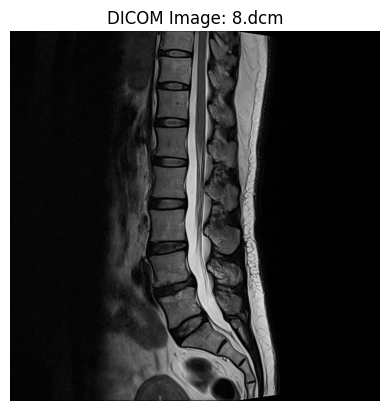

Visualizing image at path: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification//train_images/4003253/702807833/8.dcm


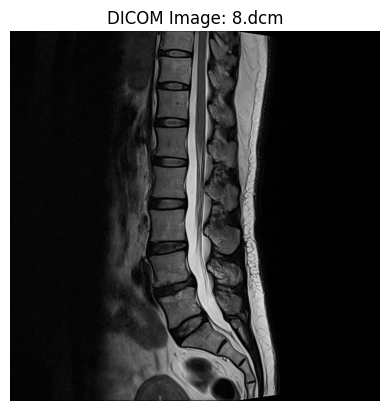

Visualizing image at path: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification//train_images/4003253/702807833/8.dcm


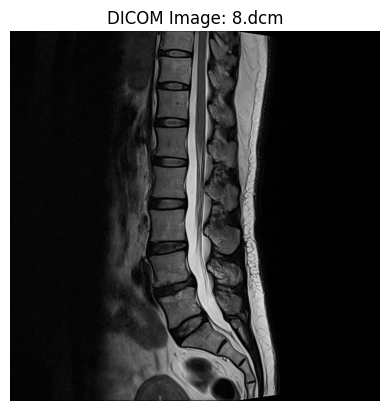

In [35]:
import pydicom
import matplotlib.pyplot as plt

# Function to visualize DICOM images
def visualize_dicom_image(image_path):
    # Read the DICOM file
    ds = pydicom.dcmread(image_path)
    img = ds.pixel_array  # Extract the pixel data

    # Plot the image
    plt.imshow(img, cmap='gray')
    plt.title(f"DICOM Image: {image_path.split('/')[-1]}")  
    plt.axis('off')  # Hide the axis
    plt.show()

# Visualize a few images from the DataFrame
for index, row in final_df.head(3).iterrows():  
    image_path = row['image_path']
    print(f"Visualizing image at path: {image_path}")
    visualize_dicom_image(image_path)


In [36]:
final_df[final_df["severity"] == "moderate"].value_counts().sum()

7950

## condition Mapping to **test data**

In [37]:
condition_mapping = {
    'Sagittal T1': {'left': 'left_neural_foraminal_narrowing', 'right': 'right_neural_foraminal_narrowing'},
    'Axial T2': {'left': 'left_subarticular_stenosis', 'right': 'right_subarticular_stenosis'},
    'Sagittal T2/STIR': 'spinal_canal_stenosis'
}


In [38]:
base_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/'


In [39]:
def get_image_paths(row):
    series_path = os.path.join(base_path, str(row['study_id']), str(row['series_id']))
    if os.path.exists(series_path):
        return [os.path.join(series_path, f) for f in os.listdir(series_path) if os.path.isfile(os.path.join(series_path, f))]
    return []


## add condition column in test df

In [40]:
expanded_rows = []
for index, row in test_description.iterrows():
    image_paths = get_image_paths(row)
    conditions = condition_mapping.get(row['series_description'], {})
    if isinstance(conditions, str):  # Single condition
        conditions = {'left': conditions, 'right': conditions}
    for side, condition in conditions.items():
        for image_path in image_paths:
            expanded_rows.append({
                'study_id': row['study_id'],
                'series_id': row['series_id'],
                'series_description': row['series_description'],
                'image_path': image_path,
                'condition': condition,
                'row_id': f"{row['study_id']}_{condition}"
            })


In [41]:
test_df = pd.DataFrame(expanded_rows)
test_df.sample(6)

,study_id,series_id,series_description,image_path,condition,row_id
148,44036939,3844393089,Sagittal T2/STIR,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,spinal_canal_stenosis,44036939_spinal_canal_stenosis
131,44036939,3481971518,Axial T2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,right_subarticular_stenosis,44036939_right_subarticular_stenosis
96,44036939,3481971518,Axial T2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_subarticular_stenosis,44036939_left_subarticular_stenosis
25,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,right_neural_foraminal_narrowing,44036939_right_neural_foraminal_narrowing
132,44036939,3481971518,Axial T2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,right_subarticular_stenosis,44036939_right_subarticular_stenosis
146,44036939,3844393089,Sagittal T2/STIR,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,spinal_canal_stenosis,44036939_spinal_canal_stenosis


# Data Preprocessing

## Create Augmented DataFrame

In [42]:
import os
import cv2
import pydicom
import pandas as pd
def augment_image_and_label(image_path, label, save_dir):
    # Read the DICOM image
    ds = pydicom.dcmread(image_path)
    img = ds.pixel_array
    
    flipped_img = cv2.flip(img, 1)

    if isinstance(label, str):
        # Update the label by swapping left and right
        if 'left' in label.lower():
            updated_label = label.replace('Left', 'Right').replace('left', 'right')
        elif 'right' in label.lower():
            updated_label = label.replace('Right', 'Left').replace('right', 'left')
        else:
            updated_label = label  # No update for non-left/right labels
    else:
        # Handle cases where the label is missing (e.g., NaN)
        updated_label = label  # You could also set it to a default value like 'Unknown'

    # Define the path for the flipped image (save as PNG for simplicity)
    flipped_image_path = os.path.join(save_dir, os.path.basename(image_path).replace('.dcm', '_flipped.png'))
    
    # Save the flipped image (as .png, but you could choose another format)
    cv2.imwrite(flipped_image_path, flipped_img)
    
    return flipped_image_path, updated_label

# Function to create an augmented DataFrame
def create_augmented_dataframe(original_df, save_dir):
    augmented_data = []

    for idx, row in original_df.iterrows():
        image_path = row['image_path']
        label = row['severity']
        
        # Skip if the image path or label is missing
        if pd.isna(image_path) or pd.isna(label):
            continue

        # Flip the image and get the updated label and image path
        flipped_image_path, updated_label = augment_image_and_label(image_path, label, save_dir)
        
        # Create a new row for the flipped image
        new_row = row.copy()
        new_row['image_path'] = flipped_image_path
        new_row['severity'] = updated_label
        
        # Add the new row to augmented data
        augmented_data.append(new_row)

    # Convert augmented data to DataFrame
    augmented_df = pd.DataFrame(augmented_data)
    
    return augmented_df 

In [43]:
save_dir = '/kaggle/working/augmented_images'  
os.makedirs(save_dir, exist_ok=True)

# Create the augmented df
augmented_df = create_augmented_dataframe(final_df, save_dir)

# Preview the augmented DataFrame
augmented_df.head()

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,/kaggle/working/augmented_images/8_flipped.png
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3,/kaggle/working/augmented_images/8_flipped.png
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4,/kaggle/working/augmented_images/8_flipped.png
3,4003253,Spinal Canal Stenosis,L4/L5,normal_mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l4_l5,/kaggle/working/augmented_images/8_flipped.png
4,4003253,Spinal Canal Stenosis,L5/S1,normal_mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l5_s1,/kaggle/working/augmented_images/8_flipped.png


In [44]:
# Preview the augmented DataFrame
augmented_df.head()

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,/kaggle/working/augmented_images/8_flipped.png
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3,/kaggle/working/augmented_images/8_flipped.png
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4,/kaggle/working/augmented_images/8_flipped.png
3,4003253,Spinal Canal Stenosis,L4/L5,normal_mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l4_l5,/kaggle/working/augmented_images/8_flipped.png
4,4003253,Spinal Canal Stenosis,L5/S1,normal_mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l5_s1,/kaggle/working/augmented_images/8_flipped.png


## Verify Augmented DataFrame

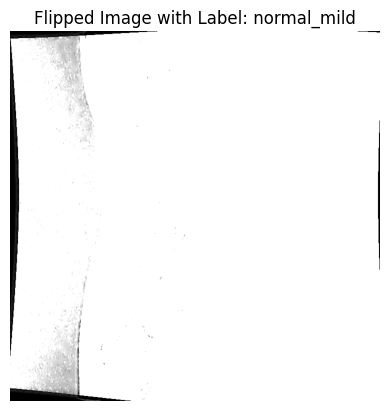

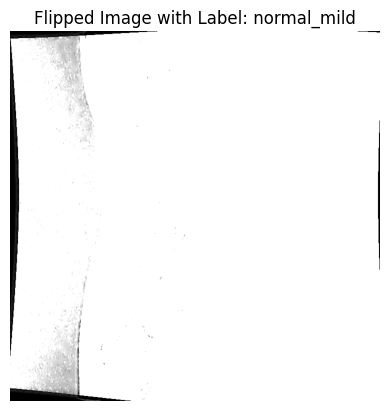

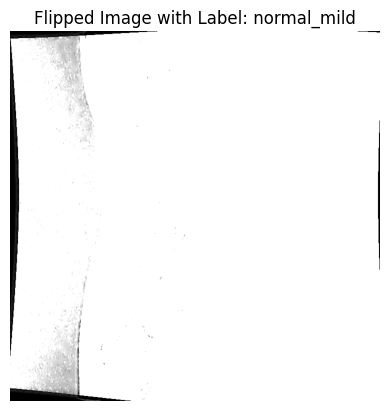

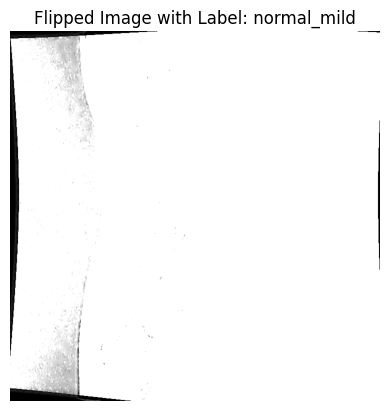

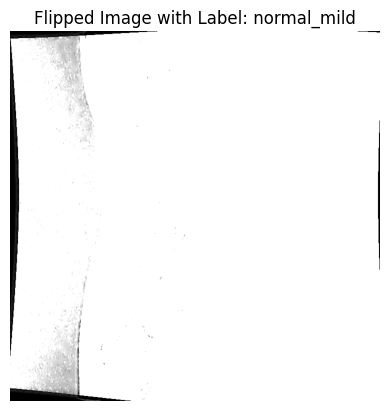

In [45]:
for i in range(5): 
    flipped_image_path = augmented_df.iloc[i]['image_path']
    updated_label = augmented_df.iloc[i]['severity']
    
    # Load the flipped image
    flipped_img = cv2.imread(flipped_image_path, cv2.IMREAD_GRAYSCALE)
    
    # Display the flipped image
    plt.imshow(flipped_img, cmap='gray')
    plt.title(f"Flipped Image with Label: {updated_label}")
    plt.axis('off')
    plt.show()


## Concatenate with the Original DataFrame

In [46]:
# Concatenate the original and augmented DataFrames
augmented_df_full = pd.concat([final_df, augmented_df], ignore_index=True)

# Check the new DataFrame shape
print(f"Original dataset size: {len(final_df)}")
print(f"Augmented dataset size: {len(augmented_df_full)}")


Original dataset size: 48692
Augmented dataset size: 97349


In [47]:
import os

# Specify the output directory
output_dir = '/kaggle/working/output'
working_dir = '/kaggle/working'  # Working directory

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define file names
csv_file_name = 'augmented_df_full.csv'
pkl_file_name = 'augmented_data.pkl'

# Save as a CSV file to both directories
augmented_df_full.to_csv(os.path.join(working_dir, csv_file_name), index=False)
augmented_df_full.to_csv(os.path.join(output_dir, csv_file_name), index=False)

# Save as a pickle file to both directories
augmented_df_full.to_pickle(os.path.join(working_dir, pkl_file_name))
augmented_df_full.to_pickle(os.path.join(output_dir, pkl_file_name))

print(f"DataFrame saved as CSV to {working_dir}/{csv_file_name} and {output_dir}/{csv_file_name}")
print(f"DataFrame saved as Pickle to {working_dir}/{pkl_file_name} and {output_dir}/{pkl_file_name}")


DataFrame saved as CSV to /kaggle/working/augmented_df_full.csv and /kaggle/working/output/augmented_df_full.csv
DataFrame saved as Pickle to /kaggle/working/augmented_data.pkl and /kaggle/working/output/augmented_data.pkl


## ** restart our work from here**

In [48]:
import os
# This will help you see if the file exists in the working directory
print(os.listdir('/kaggle/working/output'))


['augmented_data.pkl', 'augmented_df_full.csv']


In [49]:
import pandas as pd
# Load from a CSV file
augmented_df_full = pd.read_csv('/kaggle/working/augmented_df_full.csv')
# Loading from pickle
augmented_df_full = pd.read_pickle('augmented_data.pkl')


# Resize and Prepare the Images for full augmented and orioginal datset

## label mapping

In [50]:
augmented_df_full.head()

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,normal_mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
1,4003253,Spinal Canal Stenosis,L2/L3,normal_mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
2,4003253,Spinal Canal Stenosis,L3/L4,normal_mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
3,4003253,Spinal Canal Stenosis,L4/L5,normal_mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l4_l5,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
4,4003253,Spinal Canal Stenosis,L5/S1,normal_mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l5_s1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...


In [51]:
augmented_df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97349 entries, 0 to 97348
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   study_id            97349 non-null  int64  
 1   condition           97349 non-null  object 
 2   level               97349 non-null  object 
 3   severity            97314 non-null  object 
 4   series_id           97349 non-null  int64  
 5   instance_number     97349 non-null  int64  
 6   x                   97349 non-null  float64
 7   y                   97349 non-null  float64
 8   series_description  97349 non-null  object 
 9   row_id              97349 non-null  object 
 10  image_path          97349 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 8.2+ MB


In [52]:
augmented_df_full.isnull().sum()

study_id               0
condition              0
level                  0
severity              35
series_id              0
instance_number        0
x                      0
y                      0
series_description     0
row_id                 0
image_path             0
dtype: int64

In [53]:
augmented_df_full = augmented_df_full.dropna()

##  the CustomDataset Class

In [54]:
import pydicom
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms

def load_image(self, image_path):
    """Load an image from a DICOM file or an augmented image."""
    if image_path.lower().endswith('.dcm'):
        # Load DICOM file
        dicom = pydicom.dcmread(image_path, force=True)
        image = dicom.pixel_array
    else:
        # Load augmented image (assumed to be in a format like PNG or JPEG)
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        if image is None:
            raise FileNotFoundError(f"Could not load image from {image_path}")

    # Convert to a format suitable for processing (e.g., uint8)
    if image.dtype != np.uint8:
        image = image.astype(np.uint8)

    # Convert grayscale to RGB
    if len(image.shape) == 2:  # Grayscale image
        image = np.stack([image] * 3, axis=-1)  # Repeat the channel

    return image



In [55]:
import os
import pydicom
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import cv2

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)  # Ensure this returns the correct length

    def load_image(self, image_path):
        """Load an image from a DICOM file or an augmented image."""
        if image_path.lower().endswith('.dcm'):
            # Load DICOM file
            dicom = pydicom.dcmread(image_path, force=True)
            image = dicom.pixel_array
        else:
            # Load augmented image (assumed to be in a format like PNG or JPEG)
            image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
            if image is None:
                raise FileNotFoundError(f"Could not load image from {image_path}")

        # Convert to a format suitable for processing (e.g., uint8)
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)

        # Convert grayscale to RGB if the image has a single channel
        if len(image.shape) == 2:  # Check if the image is grayscale
            image = np.stack([image] * 3, axis=-1)  # Repeat the channel to make it RGB

        return image


    def __getitem__(self, index):
        image_path = self.dataframe['image_path'].iloc[index]
        label = self.dataframe['severity'].iloc[index]
        
        # Load the image
        image = self.load_image(image_path)
        if image is None:
            image = np.zeros((224, 224), dtype=np.uint8)

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        # Ensure the label is a tensor or return as-is
        label = torch.tensor(label) if isinstance(label, (int, float)) else label

        return image, label


## Applying Transformations and Preparing Dataloaders

In [56]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader



### transformer


In [57]:
transform = transforms.Compose([
    transforms.ToPILImage(),  # array to PIL Image
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # normalize to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


## train test splits

In [58]:
train_df, val_df = train_test_split(augmented_df_full, test_size=0.2, random_state=42)

In [59]:
# Create datasets
train_dataset = CustomDataset(train_df, transform=transform)
val_dataset = CustomDataset(val_df, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# train_loader and val_loader are ready for training  model

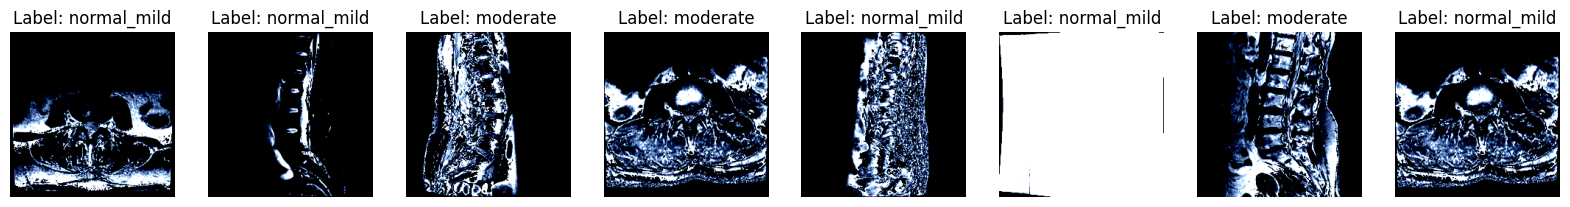

In [60]:
# proceed to visualize the images
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
for i in range(len(images)):
    img = images[i].permute(1, 2, 0)  # Convert from CHW to HWC
    ax = axes[i]
    ax.imshow(img.numpy(), cmap='gray' if img.shape[2] == 1 else None)
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

plt.show()

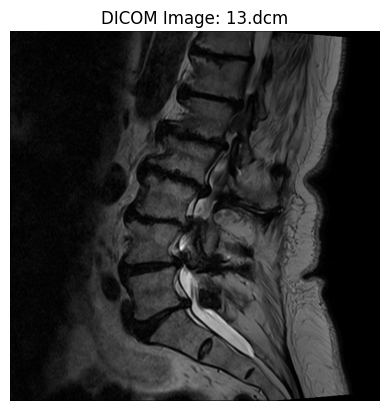

In [61]:
import pydicom
import matplotlib.pyplot as plt

# Load the DICOM file with force=True
try:
    ds = pydicom.dcmread(image_path, force=True)
    
    # Extract the pixel array and visualize
    img = ds.pixel_array
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"DICOM Image: {os.path.basename(image_path)}")
    plt.show()
except Exception as e:
    print(f"Error loading DICOM file: {e}")


# Fine-Tuning EfficientNet

In [62]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd


In [63]:
import torch
import torch.nn as nn
import torchvision.models as models

class UnifiedEfficientNetV2(nn.Module):
    def __init__(self, num_classes=3, num_features=10):
        super(UnifiedEfficientNetV2, self).__init__()
        
        # Load the model with pretrained weights
        self.model = models.efficientnet_v2_s(weights='DEFAULT')  
        
        # Capture in_features from the last layer of the original classifier
        in_features = self.model.classifier[-1].in_features
        
        # Replace the classifier with an identity function
        self.model.classifier = nn.Identity()
        
        # Define fully connected layers
        self.fc1 = nn.Linear(in_features , 256)  
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
    # Get EfficientNet embeddings
        embeddings = self.model(x)

    # Pass embeddings through the fully connected layers
        x = self.fc1(embeddings)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

    def unfreeze_model(self):
        # Unfreeze the last 20 layers, keeping BatchNorm layers frozen
        for layer in list(self.model.features.children())[-20:]:
            if not isinstance(layer, nn.BatchNorm2d):
                for param in layer.parameters():
                    param.requires_grad = True
        
        # Unfreeze the classifier
        for param in self.model.classifier.parameters():
            param.requires_grad = True

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the unified model with numerical feature size 
num_features = 10
unified_model = UnifiedEfficientNetV2(num_classes=3, num_features=num_features).to(device)

# Freeze initial layers
for param in unified_model.model.features.parameters():
    param.requires_grad = False

# Unfreeze the final fully connected layer
for param in unified_model.model.classifier.parameters():
    param.requires_grad = True


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 88.9MB/s]


# Now models are ready for training or fine-tuning

### Loss Function and Optimizer

In [64]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unified_model.parameters(), lr=0.001)


In [65]:
# Count trainable parameters
trainable_params = sum(p.numel() for p in unified_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")


Number of trainable parameters: 361219


In [66]:
import torch.optim.lr_scheduler as lr_scheduler
from copy import deepcopy
from tqdm import tqdm

def train_model(model, trainloader, valloader, len_train, len_val, optimizer, criterion, num_epochs=10, patience=3):
    # Learning rate scheduler
    scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    
    best_val_acc = 0.0
    best_model_wts = deepcopy(model.state_dict())
    counter = 0

    # Define the label mapping here
    mapping_labels = {
        'normal_mild': 0,
        'moderate': 1,
        'severe': 2
    }
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        
        with tqdm(trainloader, unit="batch") as tepoch:
            for images, labels in tepoch:
                images = images.to(device)
                # Map string labels to numerical labels
                labels = torch.tensor([mapping_labels[label] for label in labels]).to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                probabilities = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(probabilities, 1)
                correct_train += (predicted == labels).sum().item()
                
                tepoch.set_postfix(epoch=epoch+1)
        
        scheduler.step()
        
        train_loss /= len(trainloader)
        train_acc = 100 * correct_train / len_train
        
        # Validation
        model.eval()
        val_loss, correct_val = 0, 0
        with torch.no_grad():
            with tqdm(valloader, unit="batch") as vepoch:
                for images, labels in vepoch:
                    images = images.to(device)
                    # Map string labels to numerical labels for validation
                    labels = torch.tensor([mapping_labels[label] for label in labels]).to(device)
                    
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    
                    probabilities = torch.softmax(outputs, dim=1)
                    _, predicted = torch.max(probabilities, 1)
                    correct_val += (predicted == labels).sum().item()
                    
                    vepoch.set_postfix(epoch=epoch+1)
        
        val_loss /= len(valloader)
        val_acc = 100 * correct_val / len_val
        
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = deepcopy(model.state_dict())
            # Save the model to the output directory
            model_save_path = os.path.join(output_dir, 'best_model.pth')
            torch.save(best_model_wts, model_save_path)
            print(f"Best model saved to {model_save_path}")
            counter = 0  # Reset counter if validation accuracy improves
        else:
            counter += 1
        
        # Early stopping
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_val_acc


In [67]:
trained_model, best_accuracy = train_model(
    unified_model, 
    train_loader, 
    val_loader, 
    len(train_loader.dataset), 
    len(val_loader.dataset), 
    optimizer, 
    criterion, 
    num_epochs=10, 
    patience=3
)


100%|██████████| 2433/2433 [05:16<00:00,  7.68batch/s, epoch=1]


Epoch 1, Train Loss: 0.7056, Train Acc: 76.70%, Val Loss: 0.6652, Val Acc: 77.15%
Best model saved to /kaggle/working/output/best_model.pth


100%|██████████| 2433/2433 [05:11<00:00,  7.80batch/s, epoch=2]


Epoch 2, Train Loss: 0.7106, Train Acc: 76.23%, Val Loss: 0.6775, Val Acc: 77.13%


100%|██████████| 2433/2433 [05:07<00:00,  7.91batch/s, epoch=3]


Epoch 3, Train Loss: 0.6610, Train Acc: 77.33%, Val Loss: 0.6516, Val Acc: 77.12%


100%|██████████| 2433/2433 [05:09<00:00,  7.85batch/s, epoch=4]

Epoch 4, Train Loss: 0.6561, Train Acc: 77.37%, Val Loss: 0.6517, Val Acc: 77.14%
Early stopping triggered after 4 epochs


# interference

In [68]:
test_df.head()

,study_id,series_id,series_description,image_path,condition,row_id
0,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
1,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
2,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
3,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
4,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing


In [69]:
augmented_df_full['level'].unique()

array(['L1/L2', 'L2/L3', 'L3/L4', 'L4/L5', 'L5/S1'], dtype=object)

In [70]:
# Levels for row_id
levels = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']

# update row_id with levels
def update_row_id(row, levels):
    level = levels[row.name % len(levels)]  
    return f"{row['study_id']}_{row['condition']}_{level}"

# Update row_id in expanded_test_desc to include levels
test_df['row_id'] = test_df.apply(lambda row: update_row_id(row, levels), axis=1)

test_df.head()

,study_id,series_id,series_description,image_path,condition,row_id
0,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing_l1_l2
1,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing_l2_l3
2,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing_l3_l4
3,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing_l4_l5
4,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing_l5_s1


In [103]:
model = unified_model  # Initialize the model structure
model.load_state_dict(torch.load('/kaggle/working/output/best_model.pth'))
model.eval()  

/tmp/ipykernel_36/3303536589.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/output/best_model.pth'))


UnifiedEfficientNetV2(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): Batc

In [121]:
import pydicom
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms
import torch

def load_dicom(image_path):
    """Load an image from a DICOM file."""
    try:
        dicom = pydicom.dcmread(image_path, force=True)
        image = dicom.pixel_array
        # Convert to uint8 if not already in that format
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)
        # Convert grayscale to RGB if needed
        if len(image.shape) == 2:  # Grayscale image
            image = np.stack([image] * 3, axis=-1)  # Repeat the channel
        return image
    except Exception as e:
        raise FileNotFoundError(f"Error loading DICOM file {image_path}: {str(e)}")

class CustomTestDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_path = self.dataframe['image_path'].iloc[index]  # Ensure using iloc for safe access
        image = load_dicom(image_path)
        
        if self.transform:
            image = self.transform(image)
        
         # Create row_data as a dictionary for the current index
        row_data = {
            'row_id': self.dataframe['row_id'].iloc[index],
            # Add other fields as necessary
        }
        return image, row_data

In [122]:
transform = transforms.Compose([
    transforms.ToPILImage(),  # array to PIL Image
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Grayscale(num_output_channels=3),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [123]:
test_dataset = CustomTestDataset(test_df, transform=transform)  
# Step 2: Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [126]:
# Set the model to evaluation mode
model.eval()

# Initialize a dictionary to store the results
results = {
    'row_id': [],
    'normal_mild': [],
    'moderate': [],
    'severe': []
}

# Display initial message
print("Starting inference on the test set...")

# Use tqdm to create a progress bar for the test_loader
with torch.no_grad():  # Disable gradient computation for inference
    for batch_idx, (images, row_data) in enumerate(tqdm(test_loader, desc="Processing batches")):
        
        # Move data to the appropriate device
        images = images.to(device)

        # Forward pass through the model
        outputs = model(images)

        # Get the predicted probabilities using softmax
        probs = torch.softmax(outputs, dim=1).cpu().numpy()

        # Calculate batch indices
        batch_start = batch_idx * test_loader.batch_size
        
        probs = torch.softmax(outputs, dim=1).cpu().numpy()

        # Iterate through each sample in the batch
        for i in range(len(probs)):
            row_id = row_data['row_id'][i] 
            

            # Append the result for this row
            results['row_id'].append(row_id)
            results['normal_mild'].append(probs[i][0])  # Probability for 'Normal/Mild'
            results['moderate'].append(probs[i][1])     # Probability for 'Moderate'
            results['severe'].append(probs[i][2])       # Probability for 'Severe'

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)


Starting inference on the test set...


Processing batches: 100%|██████████| 25/25 [00:05<00:00,  4.46it/s]


In [128]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   row_id       194 non-null    object 
 1   normal_mild  194 non-null    float32
 2   moderate     194 non-null    float32
 3   severe       194 non-null    float32
dtypes: float32(3), object(1)
memory usage: 3.9+ KB


In [127]:
results_df.head()

,row_id,normal_mild,moderate,severe
0,44036939_left_neural_foraminal_narrowing_l1_l2,0.761828,0.200404,0.037768
1,44036939_left_neural_foraminal_narrowing_l2_l3,0.831486,0.125765,0.042749
2,44036939_left_neural_foraminal_narrowing_l3_l4,0.773866,0.162267,0.063867
3,44036939_left_neural_foraminal_narrowing_l4_l5,0.873925,0.092760,0.033315
4,44036939_left_neural_foraminal_narrowing_l5_s1,0.869792,0.111927,0.018281


In [129]:
study_id_counts = results_df['row_id'].str.split('_').str[0].value_counts()
print("Study ID counts (should be equal for each study_id):")
print(study_id_counts.head())


Study ID counts (should be equal for each study_id):
row_id
44036939    194
Name: count, dtype: int64


In [132]:
averaged_results_df = results_df.groupby('row_id', as_index=False).mean()
# Normalize probabilities to ensure they sum to 1
sum_probs = averaged_results_df[['normal_mild', 'moderate', 'severe']].sum(axis=1)
averaged_results_df['normal_mild'] = averaged_results_df['normal_mild'] / sum_probs
averaged_results_df['moderate'] = averaged_results_df['moderate'] / sum_probs
averaged_results_df['severe'] = averaged_results_df['severe'] / sum_probs


In [133]:
# Verify that the sum of probabilities is 1 for each row
averaged_results_df['sum_check'] = averaged_results_df[['normal_mild', 'moderate', 'severe']].sum(axis=1).apply(lambda x: round(x, 2))
print("Normalization Check:")
print(averaged_results_df[['row_id', 'sum_check']].head())


Normalization Check:
                                           row_id  sum_check
0  44036939_left_neural_foraminal_narrowing_l1_l2        1.0
1  44036939_left_neural_foraminal_narrowing_l2_l3        1.0
2  44036939_left_neural_foraminal_narrowing_l3_l4        1.0
3  44036939_left_neural_foraminal_narrowing_l4_l5        1.0
4  44036939_left_neural_foraminal_narrowing_l5_s1        1.0


In [134]:
# Create the final submission DataFrame
final_submission_df = averaged_results_df[['row_id', 'normal_mild', 'moderate', 'severe']]

In [135]:
# Display the final submission DataFrame for verification
print("Final Submission DataFrame:")
final_submission_df.head()

Final Submission DataFrame:


,row_id,normal_mild,moderate,severe
0,44036939_left_neural_foraminal_narrowing_l1_l2,0.804031,0.155411,0.040557
1,44036939_left_neural_foraminal_narrowing_l2_l3,0.811413,0.143275,0.045312
2,44036939_left_neural_foraminal_narrowing_l3_l4,0.826024,0.136960,0.037015
3,44036939_left_neural_foraminal_narrowing_l4_l5,0.818941,0.141572,0.039487
4,44036939_left_neural_foraminal_narrowing_l5_s1,0.823442,0.141951,0.034607


In [140]:
final_submission_df

,row_id,normal_mild,moderate,severe
0,44036939_left_neural_foraminal_narrowing_l1_l2,0.804031,0.155411,0.040557
1,44036939_left_neural_foraminal_narrowing_l2_l3,0.811413,0.143275,0.045312
2,44036939_left_neural_foraminal_narrowing_l3_l4,0.826024,0.136960,0.037015
3,44036939_left_neural_foraminal_narrowing_l4_l5,0.818941,0.141572,0.039487
4,44036939_left_neural_foraminal_narrowing_l5_s1,0.823442,0.141951,0.034607
5,44036939_left_subarticular_stenosis_l1_l2,0.661769,0.206863,0.131368
6,44036939_left_subarticular_stenosis_l2_l3,0.691192,0.219587,0.089220
7,44036939_left_subarticular_stenosis_l3_l4,0.694522,0.205432,0.100046
8,44036939_left_subarticular_stenosis_l4_l5,0.723625,0.190169,0.086206
9,44036939_left_subarticular_stenosis_l5_s1,0.688069,0.209878,0.102053


In [136]:
# Save the final submission file to CSV
final_submission_df.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'.")

Submission file saved as 'submission.csv'.


In [141]:
# Save the submission file
final_submission_df.to_csv('/kaggle/working/submission.csv', index=False)